### 할당된 GPU 확인

In [ ]:
!nvidia-smi

Fri Jun 11 04:38:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Drive mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 필요한 library 및 자료 다운로드

In [ ]:
!pip install  mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers
!pip install torch

     |████████████████████████████████| 46.9MB 102kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 348kB 12.8MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp37-cp37m-linux_x86_64.whl size=595687 sha256=84b20869c5bb6fac6a5df7cac9b8e4e50d2aac4ced5d46a80e0c796375d95753
  Stored in directory: /root/.cache/pip/wheels/37/65/52/63032864a0f31a08b9a88569f803b5bafac8abd207fd7f7534
Successfully built gluonnlp
     |████████████████████████████████| 1.2MB 14.0MB/s 
     |████████████████████████████████| 2.3MB 14.6MB/s 
     |████████████████████████████████| 3.3MB 45.7MB/s 
     |████████████████████████████████| 901kB 63.7MB/s 


In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook

In [ ]:
from transformers import AdamW, BertModel
from transformers.optimization import get_cosine_schedule_with_warmup

### gpu 사용

In [ ]:
##GPU 사용 시
device = torch.device("cuda:0")

### Pretrained bert, vocab download
####vocab은 문장에 있는 단어 나눌 때 사용됨, 형태소 사전같은 걸로 생각하면 된다

In [ ]:
#bertmodel, vocab = get_pytorch_kobert_model()
#bertmodel = get_kobert_model()

model_path = '/content/drive/MyDrive/kobert_from_pretrained'
vocab_file = '/content/drive/MyDrive/kobert_news_wiki_ko_cased-1087f8699e.spiece'
bertmodel = BertModel.from_pretrained(model_path)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(vocab_file, padding_token='[PAD]')

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

### 우리가 사용하는 dataset 가져와서 train, validation, test set으로 분류

In [ ]:
file1 = '/content/drive/MyDrive/problem_ner_multilabel_re_addonlykorean_replacevariable_replacenumber.csv'
file2 = '/content/drive/MyDrive/problem_ner_min_re_275_addonlykorean_replacevariable_replacenumber.csv'
file3 = '/content/drive/MyDrive/ner_preprocessed_complete_re_drop_addonlykorean_replacevariable_replacenumber.csv'

In [ ]:
df = pd.read_csv(file1)

In [ ]:
for i in target_name :
  sum = df[i].sum()
  print(i + ': {}'.format(sum))
print('Data size : {}' .format(df.shape[0]))

Mathematics: 1250
Dynamic_programming: 875
Implementation: 851
Graph_theory: 698
Data_structures: 620
Greedy: 354
String: 365
Graph_traversal: 367
Bruteforcing: 316
Tree: 228
Binary_search: 242
Number_theory: 266
Breadth_first_search: 214
Depth_first_search: 125
Dijkstras: 114
Divide_and_conquer: 101
Stack: 59
Priority_queue: 72
Data size : 4179


### 분류한 dataset을 형식에 맞게 변환하는 코드

In [ ]:
def set_data(dataframe) :
  dataset = []
  for index, row in df.iterrows():
    desc = row['desc_variabel_renumber_0']
    if not pd.isna(row['input_variabel_renumber_0']) :
       desc = desc + row['input_variabel_renumber_0'] 


    dataset.append([desc , 0])
  return dataset

In [ ]:
dataset = set_data(df)

### tokenizer는 문장을 단어로 나눠주는 역할을 한다

In [ ]:
#tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(vocab_file, vocab, lower=False)

### 데이터셋 관련 코드

In [ ]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))


### model parameter


In [ ]:
## Setting parameters
max_len = 512
batch_size = 8

### 데이터 셋 표준화 과정

In [ ]:
data_all = BERTDataset(dataset, 0, 1, tok, max_len, True, False)

In [ ]:
dataloader = torch.utils.data.DataLoader(data_all, batch_size=batch_size, num_workers=4)

In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=2,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate

    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        op, _ = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device), return_dict=False)
        x = op[:,:16, :]
        y = op[:,-48:, :]
        output = torch.cat((x,y), dim = 1)
        return output

### model 할당

In [ ]:
model = BERTClassifier(bertmodel).to(device) 

# vector 뽑아내는 단계

In [ ]:
output = []

with torch.no_grad():
  model.eval()
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(dataloader)):
    token_ids = token_ids.long().to(device)
    segment_ids = segment_ids.long().to(device)
    valid_length= valid_length
    label = label.long().to(device)
    out = model(token_ids, valid_length, segment_ids)
    output.extend(out.to('cpu').tolist())


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [ ]:
df['vector'] = output
#df.to_csv('/content/drive/MyDrive/problem_ner_multilabel_re_vector.csv', encoding='utf-8-sig')

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Dense, concatenate, Conv1D, MaxPool1D, Dropout, Flatten
from tensorflow.keras.models import Model
from keras.regularizers import l2

In [ ]:
train_df, remaining = train_test_split(df, random_state = 46, train_size = 0.7)
valid_df, test_df = train_test_split(remaining, random_state= 46, train_size = 0.5)

In [ ]:
target_name = ['Mathematics', 'Dynamic_programming', 'Implementation', 'Graph_theory',
       'Data_structures', 'Greedy', 'String', 'Graph_traversal',
       'Bruteforcing', 'Tree', 'Binary_search', 'Number_theory',
       'Breadth_first_search', 'Depth_first_search', 'Dijkstras',
       'Divide_and_conquer', 'Stack', 'Priority_queue']

In [ ]:
def set_data_vector(df) :
  dataset = []
  labels = []
  for index, row in df.iterrows():
    label = []
    for i in target_name :
      label.append(row[i])
    dataset.append([row['vector']])
    labels.append(label)
  return np.array(dataset).squeeze(), np.array(labels)

In [ ]:
dataset_train, train_labels = set_data_vector(train_df)
dataset_valid, valid_labels = set_data_vector(valid_df)
dataset_test, test_labels = set_data_vector(test_df)

In [ ]:
dataset_test.shape

(627, 64, 768)

In [ ]:
batch_size = 32
num_epochs = 50
lr = 7e-5 #5e-5

In [ ]:
def define_tfmodel(x = 0.1, num_classes = 18) :
  kernel_num = 16
  windows = [4, 8, 16]

  vector_input = Input(shape = (64, 768),  name = "vector")
  layer_conv1 = Conv1D(kernel_num, windows[0], strides = 2, activation= 'relu', bias_regularizer=l2(0.01))
  layer_conv2 = Conv1D(kernel_num, windows[1], strides = 2, activation= 'relu', bias_regularizer=l2(0.01))
  layer_conv3 = Conv1D(kernel_num, windows[2], strides = 2, activation= 'relu', bias_regularizer=l2(0.01))
  max_pool1 = MaxPool1D(2,1)
  max_pool2 = MaxPool1D(2,1)
  max_pool3 = MaxPool1D(2,1)
  dropout = Dropout(x)

  hidden1 = layer_conv1(vector_input)
  hidden1 = max_pool1(hidden1)
  hidden1 = dropout(hidden1)

  hidden2 = layer_conv2(vector_input)
  hidden2 = max_pool2(hidden2)
  hidden2 = dropout(hidden2)

  hidden3 = layer_conv3(vector_input)
  hidden3 = max_pool3(hidden3)
  hidden3 = dropout(hidden3)

  concat = concatenate([hidden1, hidden2, hidden3], axis = 1)
  out = Flatten()(concat)
  output = Dense(num_classes, name="Output", activation = 'sigmoid')(out)
  model = Model(inputs=vector_input, outputs=output)
  opt = tf.keras.optimizers.Adam(learning_rate=lr)
  model.compile(optimizer=opt, loss = 'binary_crossentropy', metrics=['binary_accuracy'])

  return model

tf_model = define_tfmodel(0.2, 18)
#plot_model(tf_model)
  
tf_model.summary()

Model: "model_26"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
vector (InputLayer)             [(None, 64, 768)]    0                                            
__________________________________________________________________________________________________
conv1d_78 (Conv1D)              (None, 31, 16)       49168       vector[0][0]                     
__________________________________________________________________________________________________
conv1d_79 (Conv1D)              (None, 29, 16)       98320       vector[0][0]                     
__________________________________________________________________________________________________
conv1d_80 (Conv1D)              (None, 25, 16)       196624      vector[0][0]                     
___________________________________________________________________________________________

In [ ]:
history = tf_model.fit(dataset_train, train_labels, batch_size = batch_size, epochs= num_epochs, verbose = 1, validation_data=(dataset_valid, valid_labels))

### loss graph


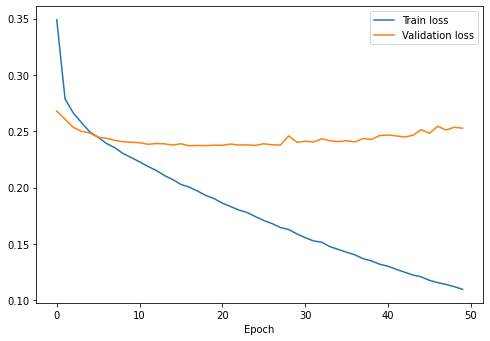

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(8,12))

  plt.subplot(2,1,1)
  plt.xlabel('Epoch')
  plt.plot(hist['epoch'], hist['loss'],
           label='Train loss')
  plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Validation loss')
  plt.legend()
  plt.show()

plot_history(history)

## predict

In [ ]:
pred_list = []
test_label = []
i = 0

output = tf_model.predict(dataset_test)
pred_list = output
test_label = test_labels

##성능 평가

In [ ]:
thresholds = [0.4, 0.34, 0.3, 0.35,
              0.25, 0.16, 0.28, 0.27,
              0.14, 0.18, 0.14, 0.28,
              0.19, 0.13, 0.2,
              0.1, 0.05, 0.06]

In [ ]:
acc = 0.0
for i in range(len(pred_list)) :
  sum = 0.0
  all = 0
  for j in range(18) :
    if pred_list[i][j] >= thresholds[j] :
      tmp = 1
    else :
      tmp = 0
    if tmp == 1 or test_label[i][j] == 1 :
      all += 1
    if test_label[i][j] == 1 and tmp == test_label[i][j] :
      sum += 1
  acc += sum / all
acc /= len(pred_list)
print('test acc : {}' .format(acc))

test acc : 0.3041410344041925


In [ ]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds, length):
    plt.plot(thresholds, precisions[:length], "b--", label='precision')
    plt.plot(thresholds, recalls[:length], "g-", label='recall')
    plt.xlabel("threshold")
    plt.legend(loc="center left")
    plt.ylim([0, 1])

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

def draw_PR_graph(test_label, pred_list, i) :
  precision, recall, _ = precision_recall_curve(test_label, pred_list)

  ap = average_precision_score(test_label, pred_list)
  plt.title(target_name[i])
  image_name = '/content/drive/MyDrive/tensor_cnn/' + target_name[i] + 'png'
  plt.xlabel('Recall')
  plt.ylabel('Precision')

  plt.plot(recall, precision, 'b', label = 'Classifier (AP = %0.2F)'%ap)   

  plt.legend(loc='upper right')
  plt.savefig(image_name)
  plt.show()

In [ ]:
from sklearn.metrics import roc_curve, auc

def draw_ROC_graph(test_label, pred_list, i) :
  false_positive_rate, true_positive_rate, thresholds = roc_curve(test_label, pred_list)
  roc_auc = auc(false_positive_rate, true_positive_rate)

  plt.title('Receiver Operating Characteristic')
  plt.xlabel('False Positive Rate(1 - Specificity)')
  plt.ylabel('True Positive Rate(Sensitivity)')

  plt.plot(false_positive_rate, true_positive_rate, 'b', label='Classifier (AUC = %0.2f)'% roc_auc)
  plt.plot([0,1],[1,1],'y--')
  plt.plot([0,1],[0,1],'r--')

  plt.title(target_name[i])
  plt.legend(loc='lower right')
  plt.show()

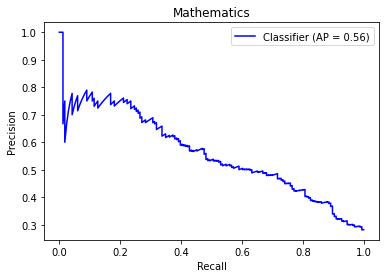

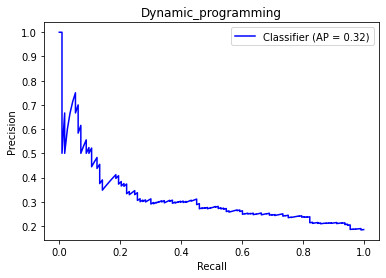

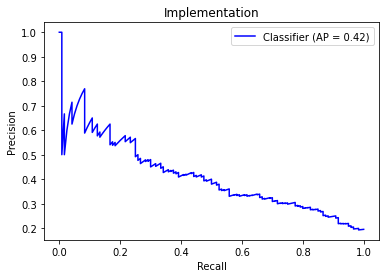

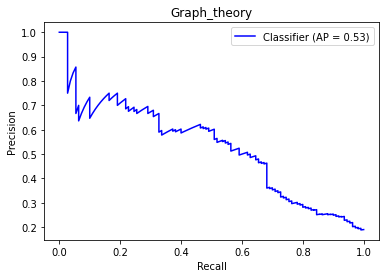

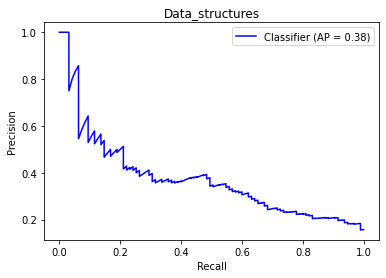

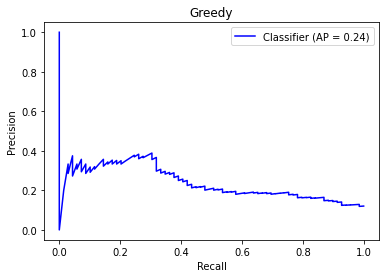

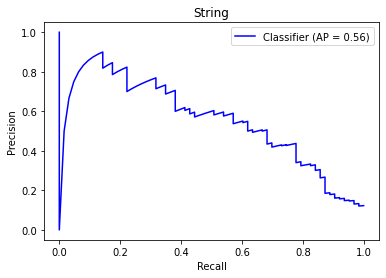

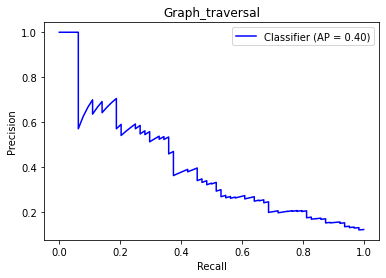

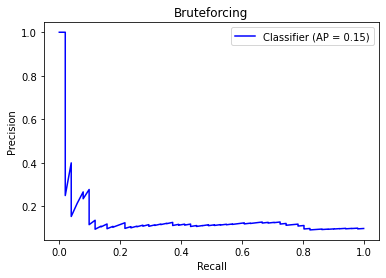

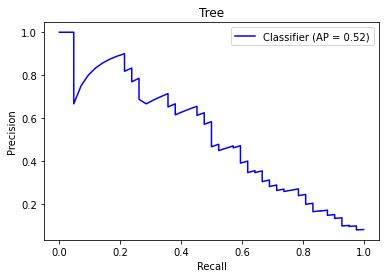

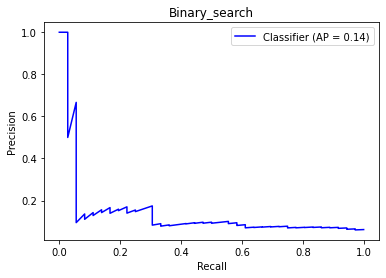

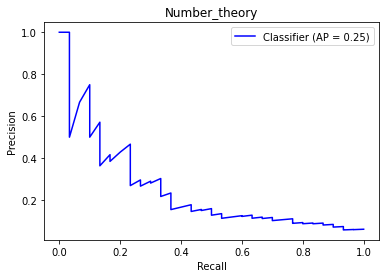

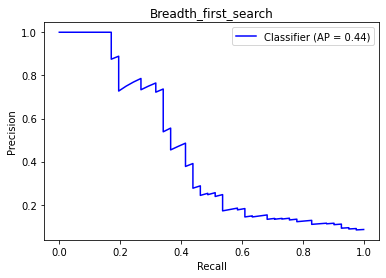

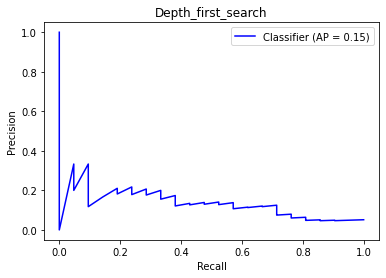

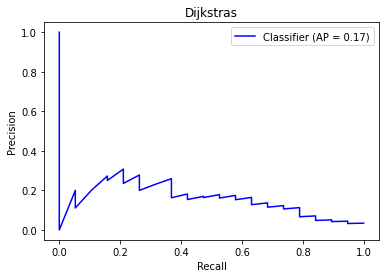

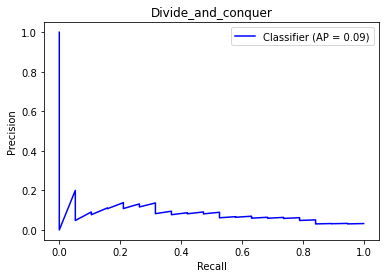

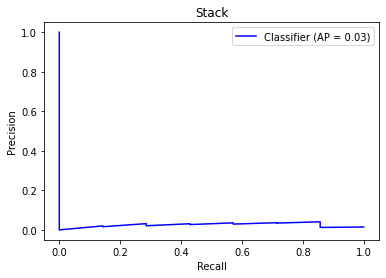

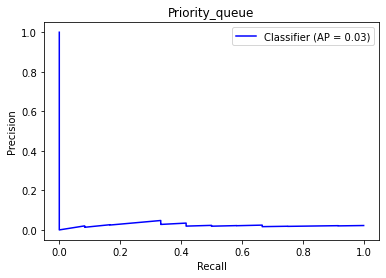

In [ ]:

for i in range(18) :
    y_scores = pred_list[:,i]
    y_true = test_label[:,i]
    draw_PR_graph(y_true, y_scores, i)

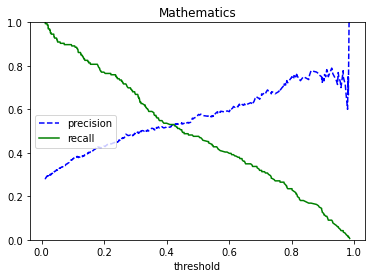

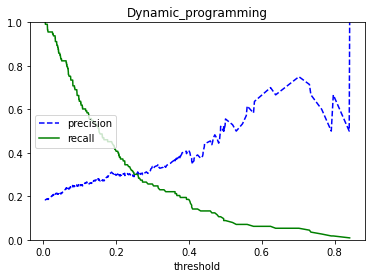

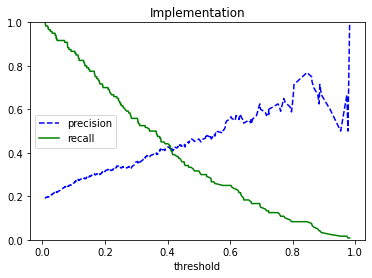

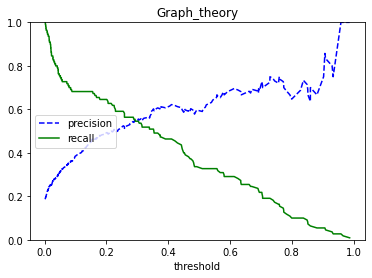

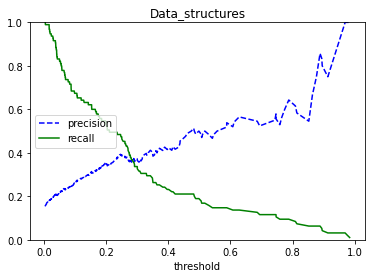

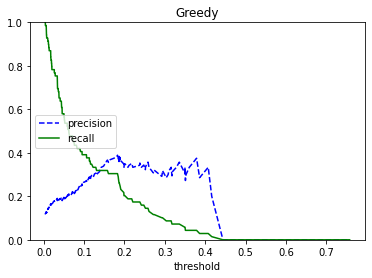

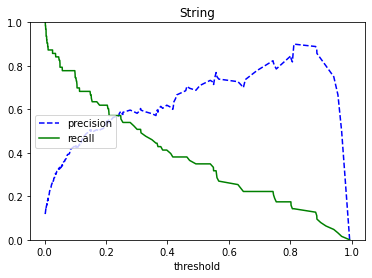

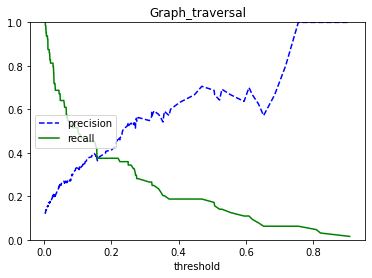

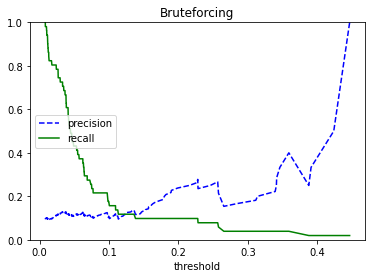

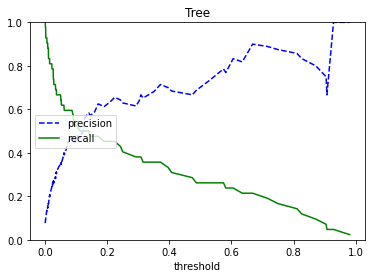

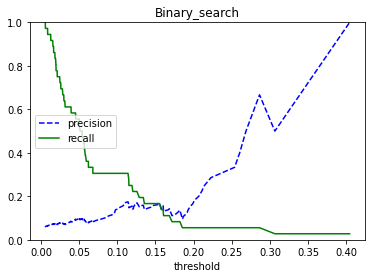

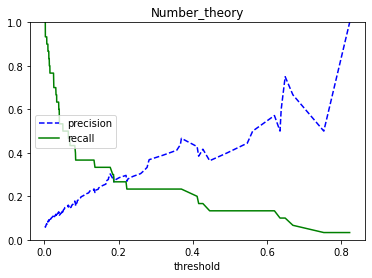

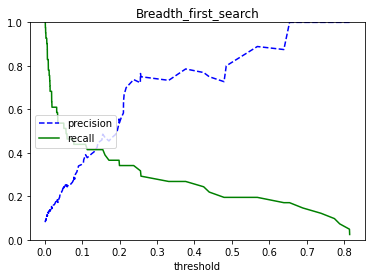

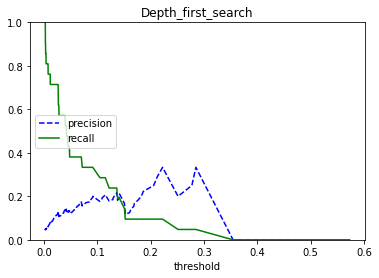

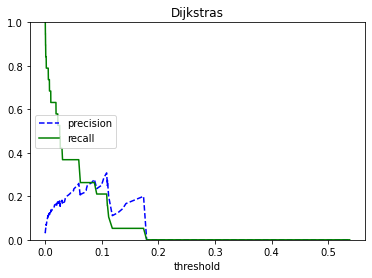

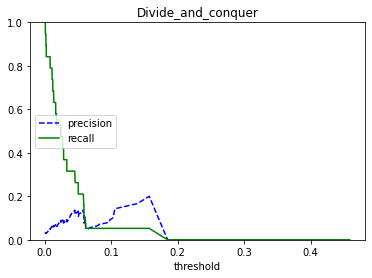

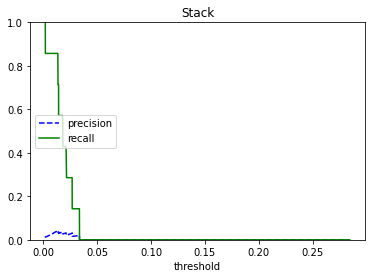

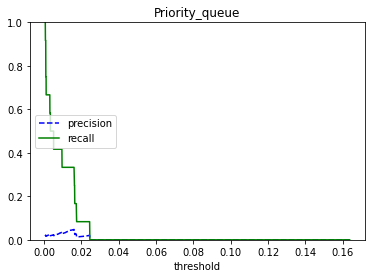

In [ ]:
for i in range(18) :
    y_scores = pred_list[:,i]
    y_true = test_label[:,i]
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    plot_precision_recall_vs_threshold(precision, recall, thresholds, len(thresholds))
    plt.title(target_name[i])
    image_name = '/content/drive/MyDrive/tensor_cnn/' + target_name[i] + 'thresholds'
    plt.savefig(image_name)
    plt.show()

### 학습한 모델 save/load

In [ ]:
import os

save_dir = '/content/drive/MyDrive/model_save/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

save_name = save_dir + "cnn_weight.h5"

In [ ]:
#tf_model.save_weights(save_name)
#tmp = define_tfmodel()
#tmp.load_weights(save_name)

### load model